# Geospatial Transformations In-depth

Instructors: [Tyler Sutterley](mailto:tsutterl@uw.edu), [Hannah Besso](mailto:bessoh2@uw.edu) and [Scott Henderson](mailto:scottyh@uw.edu)


Learning Objectives
-------------------
- Review fundamental concepts of coordinate reference systems (CRS)
- Learn how to access coordinate reference metadata
- Learn how to warp vector and raster data to different CRS

In this advanced and comprehensive notebook, we will explore coordinate systems, map projections, geophysical concepts and available geospatial software tools. 

In [1]:
# We link to the documentation of these great libraries at the end of the notebook
import builtins
import geopandas as gpd
import getpass
import matplotlib.patches
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import netCDF4
import numpy as np
import os
import osgeo.gdal, osgeo.osr
import pyproj
import rasterio
import rasterio.features
import rasterio.warp
import re
import xarray as xr
import warnings
# import routines for this notebook
import utilities
from ATL06_to_dataframe import ATL06_to_dataframe
# turn off warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Questions about space
---------------------
- Where is something located?
- What is its height?
- Does it have an extent or is it a point?

<!--
Questions about time
--------------------
- When were the location, height and extent measured?
- Have the location, height or extent changed over time?
-->

Let's Start by Making a Map
---------------------------

**Q: Why would we use maps to display geographic data?**

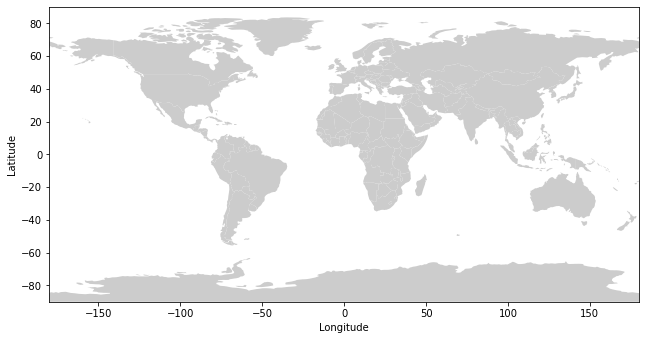

In [2]:
fig,ax1 = plt.subplots(num=1, figsize=(10,4.55))
minlon,maxlon,minlat,maxlat = (-180,180,-90,90)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax1, color='0.8', edgecolor='none')
# set x and y limits
ax1.set_xlim(minlon,maxlon)
ax1.set_ylim(minlat,maxlat)
ax1.set_aspect('equal', adjustable='box')
# add x and y labels
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
# adjust subplot and show
fig.subplots_adjust(left=0.06,right=0.98,bottom=0.08,top=0.98)

Geographic Coordinate Systems
-----------------------------
Locations on Earth are usually specified in a geographic coordinate system consisting of
- _Longitude_ specifies the angle east and west from the Prime Meridian (102 meters east of the Royal Observatory at Greenwich)
- _Latitude_ specifies the angle north and south from the Equator

The map above _projects_ geographic data from the Earth's 3-dimensional geometry on to a flat surface.  [The three common types of projections are _cylindric_, _conic_ and _planar_](https://courses.washington.edu/gis250/lessons/projection/).  Each type is a different way of flattening the Earth's geometry into 2-dimensional space.

This map is in an _Equirectangular Projection_ (Plate Carrée), where latitude and longitude are equally spaced.  Equirectangular is cylindrical projection, which has benefits as latitudes and longitudes form straight lines.  However, this projection distorts both _shape_ and _distance_, particularly at higher latitudes.



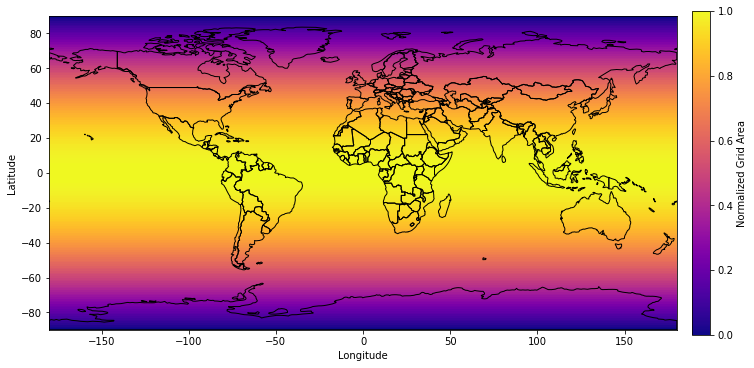

In [3]:
fig,ax1 = plt.subplots(num=1, figsize=(10.375,5.0))
minlon,maxlon,minlat,maxlat = (-180,180,-90,90)
dlon,dlat = (1.0,1.0)
longitude = np.arange(minlon,maxlon+dlon,dlon)
latitude = np.arange(minlat,maxlat+dlat,dlat)
# calculate and plot grid area
gridlon,gridlat = np.meshgrid(longitude, latitude)
im = ax1.imshow(np.cos(gridlat*np.pi/180.0),
    extent=(minlon,maxlon,minlat,maxlat), 
    interpolation='nearest',
    cmap=plt.cm.get_cmap('plasma'),
    origin='lower')
# add coastlines
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax1, color='none', edgecolor='black')
# set x and y limits
ax1.set_xlim(minlon,maxlon)
ax1.set_ylim(minlat,maxlat)
ax1.set_aspect('equal', adjustable='box')
# add x and y labels
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
# add colorbar
cbar = plt.colorbar(im, cax=fig.add_axes([0.92, 0.08, 0.025, 0.90]))
cbar.ax.set_ylabel('Normalized Grid Area')
cbar.solids.set_rasterized(True)
# adjust subplot and show
fig.subplots_adjust(left=0.06,right=0.9,bottom=0.08,top=0.98)

Notes on Projections
--------------------

_There is no perfect projection for all purposes_

Not all maps are good for ocean or land navigation

Not all projections are good for polar mapping

Every projection will distort either shape, area, distance or direction

- _conformal_ projections minimize distortion in shape
- _equal-area_ projections minimize distortion in area
- _equidistant_ projections minimize distortion in distance
- _true-direction_ projections minimize distortion in direction

While there are [projections that are better suited for specific purposes](https://pubs.usgs.gov/gip/70047422/report.pdf), [choosing a map projection](https://pubs.usgs.gov/pp/1395/report.pdf) is a bit of an art 🦋

[![](https://imgs.xkcd.com/comics/map_projections.png)](https://xkcd.com/977/)

### **Q: What is your favorite projection?** 🌎
### **Q: What projections do you use in your research?** 🌏

Reference Systems and Datums
----------------------------
Coordinates are defined to be in _reference_ to the origins of the coordinate system
- Horizontally, coordinates are in reference to the Equator and the Prime Meridian
- Vertically, heights are in reference to a [_datum_](https://vdatum.noaa.gov/docs/datums.html)

Two common vertical datums are the reference _ellipsoid_ and the reference _geoid_.

What are they and what is the difference?
- To ﬁrst approximation, the Earth is a sphere (🐄) with a radius of 6371 kilometers.
- To a better approximation, the Earth is a slightly flattened ellipsoid with the polar axis 22 kilometers shorter than the equatorial axis.
- To an even better approximation, the Earth's shape can be described using a reference geoid, which undulates 10s of meters above and below the reference ellipsoid. The difference in height between the ellipsoid and the geoid are known as _geoid heights_.

The geoid is an _equipotential surface_, perpendicular to the force of gravity at all points and with a constant geopotential. Reference ellipsoids and geoids are both created to largely coincide with mean sea level if the oceans were at rest.

An _ellipsoid can be considered a simplification of a geoid_.

![Derived from the International Centre for Global Earth Models (ICGEM)](../../img/EGM2008.png)

[PROJ hosts grids for shifting both the horizontal and vertical datum](https://cdn.proj.org/), such as gridded [EGM2008 geoid height values](https://cdn.proj.org/us_nga_egm08_25.tif)

Additional geoid height values can be calculated at the [International Centre for Global Earth Models (ICGEM)](http://icgem.gfz-potsdam.de/home)

Why Does This Matter?
---------------------

ICESat-2 elevations are in reference to the WGS84 (G1150) ellipsoid.  ICESat-2 data products also include geoid heights from the [EGM2008 geoid](https://www.usna.edu/Users/oceano/pguth/md_help/html/egm96.htm).  Different ground-based, airborne or satellite-derived elevations may use a separate datum entirely.  _Elevations have to be in the same reference frame when comparing heights_.

Different datums have different purposes.  Heights above mean sea level are needed for ocean and sea ice heights, and are also commonly used for terrestrial mapping (e.g. as elevations of mountains).  Ellipsoidal heights are commonly used for estimating land ice height change.

### **Q: What datum is right for me?**
- If it is useful to be in reference to sea level: be in reference to the geoid
- If that doesn't matter: can be in reference to the ellipsoid 
- If comparing datasets: have everything be in the same datum

![Modified from: Tapley, B. D. & M-C. Kim, Applications to Geodesy, Chapt. 10 in Satellite Altimetry and Earth Sciences, ed. by L-L. Fu & A. Cazenave, Academic Press, pp. 371-406, 2001.](../../img/IS2_surfaces_and_datums.png)

Terrestrial Reference System
----------------------------
Locations of satellites are determined in an Earth-centered cartesian coordinate system
- **X**, **Y**, and **Z** measurements from the Earth's center of mass

Presently ICESat-2 is set in the [2014 realization of the International Terrestrial Reference Frame (ITRF)](https://itrf.ign.fr/ITRF_solutions/2014/ITRF2014.php).  Other satellite and airborne altimetry missions may be in a different ITRF.

As opposed to simple vertical offsets, changing the terrestrial reference system can involve both [translation and rotation of the reference system](https://itrf.ign.fr/doc_ITRF/Transfo-ITRF2014_ITRFs.txt).  This involves converting from a geographic coordinate system into a Cartesian coordinate system.

The [NSIDC IceFlow API](https://nsidc.org/nsidc-highlights/2021/03/there-and-back-again-iceflow-data-tool) will standardize data from NASA altimetry missions to a single ITRF realization.

Let's visualize what the Cartesian coordinate system looks like:

In [4]:
def to_cartesian(lon,lat,h=0.0,a_axis=6378137.0,flat=1.0/298.257223563):
    """
    Converts geodetic coordinates to Cartesian coordinates

    Inputs:
        lon: longitude (degrees east)
        lat: latitude (degrees north)

    Options:
        h: height above ellipsoid (or sphere)
        a_axis: semimajor axis of the ellipsoid (default: WGS84)
            * for spherical coordinates set to radius of the Earth
        flat: ellipsoidal flattening (default: WGS84)
            * for spherical coordinates set to 0
    """
    # verify axes
    lon = np.atleast_1d(lon)
    lat = np.atleast_1d(lat)
    # fix coordinates to be 0:360
    lon[lon < 0] += 360.0
    # Linear eccentricity and first numerical eccentricity
    lin_ecc = np.sqrt((2.0*flat - flat**2)*a_axis**2)
    ecc1 = lin_ecc/a_axis
    # convert from geodetic latitude to geocentric latitude
    dtr = np.pi/180.0
    # geodetic latitude in radians
    latitude_geodetic_rad = lat*dtr
    # prime vertical radius of curvature
    N = a_axis/np.sqrt(1.0 - ecc1**2.0*np.sin(latitude_geodetic_rad)**2.0)
    # calculate X, Y and Z from geodetic latitude and longitude
    X = (N + h) * np.cos(latitude_geodetic_rad) * np.cos(lon*dtr)
    Y = (N + h) * np.cos(latitude_geodetic_rad) * np.sin(lon*dtr)
    Z = (N * (1.0 - ecc1**2.0) + h) * np.sin(latitude_geodetic_rad)
    # return the cartesian coordinates
    return (X,Y,Z)

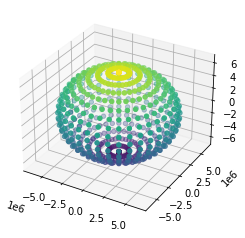

In [5]:
fig,ax2 = plt.subplots(num=2, subplot_kw=dict(projection='3d'))
minlon,maxlon,minlat,maxlat = (-180,180,-90,90)
dlon,dlat = (10.0,10.0)
longitude = np.arange(minlon,maxlon+dlon,dlon)
latitude = np.arange(minlat,maxlat+dlat,dlat)
# calculate and plot grid area
gridlon,gridlat = np.meshgrid(longitude, latitude)
X,Y,Z = to_cartesian(gridlon,gridlat)
ax2.scatter3D(X, Y, Z, c=gridlat)
plt.show()

Yep, that looks like an ellipsoid

Permanent Tidal Systems
-----------------------
Tides on the Earth are caused by the gravitational forces of the Sun and Moon. 

**Q: What do you think of when you think of tides?**

In addition to the ups and downs of tides, there is considerable part that does not vary in time, a _permanent tide_ that is due to the Earth being in the presence of the Sun and Moon.  The [Earth is lower in polar areas and higher in equatorial areas](https://www.ngs.noaa.gov/PUBS_LIB/EGM96_GEOID_PAPER/egm96_geoid_paper.html) than it would without those gravitational effects.  In effect, the Earth's crust and geoid have more of an equatorial bulge.

All of the the tidal effects, the periodic and the permanent, are typically removed from a geoid model.  These geoid models are _tide-free_.

For most use cases in the real world, we want to include the permanent tide as part of the geoid because it reflects the Earth as it is, in the solar system with the sun 🌞 and the moon 🌜.

<!--
The sun and the moon have both a direct and an indirect effect on the Earth's permanent tide.
- _Direct effect_: the actual bulge in the ocean and solid earth from the gravitational attraction
- _Indirect effect_: the elastic deformation in the Solid Earth induced by the redistribution of mass.

The direct and indirect effects of the permanent tide can be restored to _tide-free_ reference geoids.  Depending on the level of processing, geoid heights can be referred to be in one of [three different tidal systems](http://mitgcm.org/~mlosch/geoidcookbook/node9.html):
- _Mean Tide_: includes the deformation effects of the permanent tide 
- _Zero Tide_: only indirect effects of the permanent tide are restored
- _Tide-Free_: direct and indirect effects of the permanent tide are restored
-->

Since Release-4, the EGM2008 geoid heights provided in ICESat-2 products have used a _tide-free_ system.  There is a parameter included in the ICESat-2 products for converting back to a _mean tide_ system, [which restores the permanent tide components](http://mitgcm.org/~mlosch/geoidcookbook/node9.html) and coincides with with mean sea level.

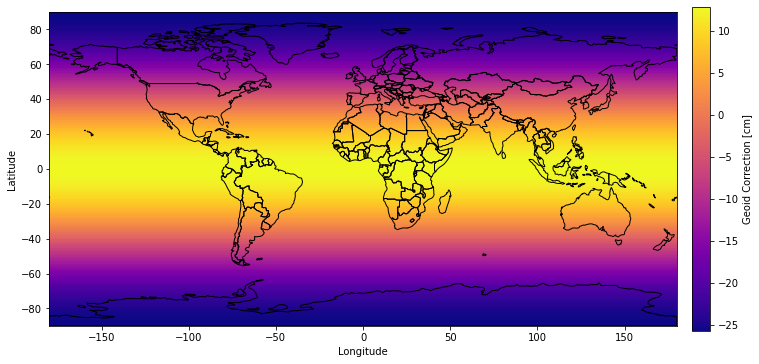

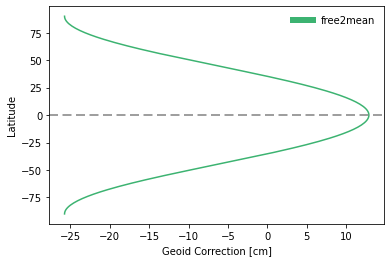

In [6]:
minlon,maxlon,minlat,maxlat = (-180,180,-90,90)
dlon,dlat = (1.0,1.0)
longitude = np.arange(minlon,maxlon+dlon,dlon)
latitude = np.arange(minlat,maxlat+dlat,dlat)
# calculate and plot permanent tide transformation
gridlon,gridlat = np.meshgrid(longitude, latitude)
theta = np.pi*(90.0 - gridlat)/180.0
# unnormalized Legendre polynomial of degree 2
P2 = 0.5*(3.0*np.cos(theta)**2 - 1.0)
# love number of degree 2 (IERS standards)
k2 = 0.3
# transformations for changing from tide-free to different permanent tides
geoid_free2mean = -0.198*(1.0 + k2)*P2
geoid_free2zero = -0.198*k2*P2
geoid_zero2mean = -0.198*P2

# plot geoid conversion from free2mean (same as in ICESat-2 products)
fig,ax1 = plt.subplots(num=1, figsize=(10.375,5.0))
im = ax1.imshow(100.0*geoid_free2mean,
    extent=(minlon,maxlon,minlat,maxlat), 
    interpolation='nearest',
    cmap=plt.cm.get_cmap('plasma'),
    origin='lower')
# add coastlines
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax1, color='none', edgecolor='black')
# set x and y limits
ax1.set_xlim(minlon,maxlon)
ax1.set_ylim(minlat,maxlat)
ax1.set_aspect('equal', adjustable='box')
# add x and y labels
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
# add colorbar
cbar = plt.colorbar(im, cax=fig.add_axes([0.92, 0.08, 0.025, 0.90]))
cbar.ax.set_ylabel('Geoid Correction [cm]')
cbar.solids.set_rasterized(True)
# adjust subplot and show
fig.subplots_adjust(left=0.06,right=0.9,bottom=0.08,top=0.98)

# show zonal averages of permanent tide transforms
fig,ax2 = plt.subplots(num=2)
ax2.plot(100.0*geoid_free2mean[:,0], latitude, color='mediumseagreen', label='free2mean')
# ax2.plot(100.0*geoid_free2zero[:,0], latitude, color='darkorchid', label='free2zero')
# ax2.plot(100.0*geoid_zero2mean[:,0], latitude, color='darkorange', label='zero2mean')
ax2.axhline(0.0, ls='--', color='0.5', dashes=(6,3))
ax2.set_xlabel('Geoid Correction [cm]')
ax2.set_ylabel('Latitude')
# add legend
lgd = ax2.legend(loc=1, frameon=False)
lgd.get_frame().set_alpha(1.0)
for line in lgd.get_lines():
    line.set_linewidth(6)
plt.show()

Coordinate Reference Systems
----------------------------

Combined, projections and vertical datums can describe a Coordinate Reference System (CRS).

There are many different ways of [detailing a coordinate reference system (CRS)](https://spatialreference.org/).  Three common CRS formats are:
1. [Well-Known Text (WKT)](https://www.ogc.org/standards/wkt-crs): can describe any coordinate reference system and is the standard for a lot of software

```
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.01745329251994328,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]
```
2. [PROJ string](https://proj.org/): shorter with some less information but can also describe any coordinate reference system

```
+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs 
```
3. [EPSG code](https://epsg.io/): simple and easy to remember

```
EPSG:4326
```

In [7]:
crs4326 = pyproj.CRS.from_epsg(4326)
crs3031 = pyproj.CRS.from_epsg(3031)
transformer = pyproj.Transformer.from_crs(crs4326, crs3031, always_xy=True)

We can use these transformers with geopandas to make a polar stereographic plot.

The Coordinate Reference System of a [geopandas GeoDataFrame can be transformed to another](http://geopandas.org/projections.html) using the `to_crs()` function.  The `to_crs()` function can import different forms including WKT strings, PROJ strings, EPSG codes and pyproj CRS objects.  The GeoDataFrame must have an original CRS before the conversion.

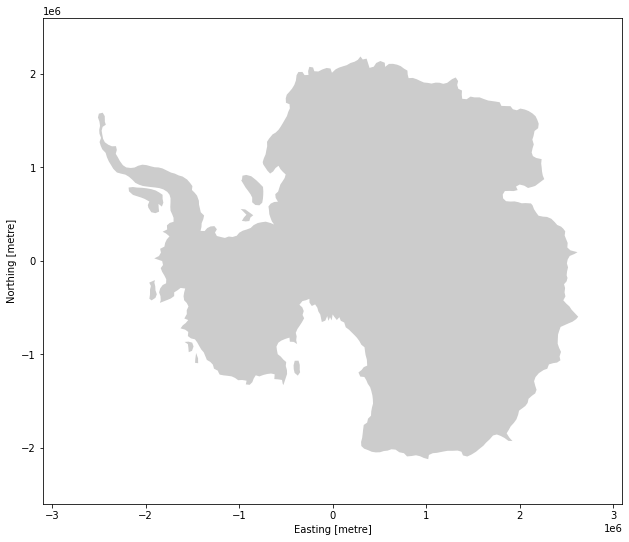

In [8]:
fig,ax3 = plt.subplots(num=3, figsize=(10,7.5))
xmin,xmax,ymin,ymax = (-3100000,3100000,-2600000,2600000)
# add coastlines
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).to_crs(crs3031)
world.plot(ax=ax3, color='0.8', edgecolor='none')
# set x and y limits
ax3.set_xlim(xmin,xmax)
ax3.set_ylim(ymin,ymax)
ax3.set_aspect('equal', adjustable='box')
# add x and y labels
x_info,y_info = crs3031.axis_info
ax3.set_xlabel('{0} [{1}]'.format(x_info.name,x_info.unit_name))
ax3.set_ylabel('{0} [{1}]'.format(y_info.name,y_info.unit_name))
# adjust subplot and show
fig.subplots_adjust(left=0.06,right=0.98,bottom=0.08,top=0.98)

Ahhh Antarctica 🐧

Stereographic projections are common for mapping in polar regions.  A lot of legacy data products for both Greenland and Antarctica use polar stereographic projections. Some other polar products, such as NSIDC EASE/EASE-2 grids, are in _equal-area_ projections.  

Stereographic projections are _conformal_, preserving angles but not distances or areas.  _Equal-area_ map projection cannot be conformal, nor can a conformal map projection be equal-area.  

_If CRS metadata on any products isn't included within the data product, make sure it's in the right projection and datum._


In [9]:
def scale_areas(lat, flat=1.0/298.257223563, ref=70.0):
    """
    Area scaling factors for a polar stereographic projection including special
        exact pole case

    Inputs:
        lat: latitude (degrees north)

    Options:
        flat: ellipsoidal flattening
        ref: reference latitude (standard parallel)

    Returns:
        scale: area scaling factors at input latitudes

    References:
        Snyder, J P (1982) Map Projections used by the U.S. Geological Survey
            Forward formulas for the ellipsoid.  Geological Survey Bulletin
            1532, U.S. Government Printing Office.
        JPL Technical Memorandum 3349-85-101
    """
    # convert latitude from degrees to positive radians
    theta = np.abs(lat)*np.pi/180.0
    # convert reference latitude from degrees to positive radians
    theta_ref = np.abs(ref)*np.pi/180.0
    # square of the eccentricity of the ellipsoid
    # ecc2 = (1-b**2/a**2) = 2.0*flat - flat^2
    ecc2 = 2.0*flat - flat**2
    # eccentricity of the ellipsoid
    ecc = np.sqrt(ecc2)
    # calculate ratio at input latitudes
    m = np.cos(theta)/np.sqrt(1.0 - ecc2*np.sin(theta)**2)
    t = np.tan(np.pi/4.0 - theta/2.0)/((1.0 - ecc*np.sin(theta)) / \
        (1.0 + ecc*np.sin(theta)))**(ecc/2.0)
    # calculate ratio at reference latitude
    mref = np.cos(theta_ref)/np.sqrt(1.0 - ecc2*np.sin(theta_ref)**2)
    tref = np.tan(np.pi/4.0 - theta_ref/2.0)/((1.0 - ecc*np.sin(theta_ref)) / \
        (1.0 + ecc*np.sin(theta_ref)))**(ecc/2.0)
    # distance scaling for general and polar case
    k = (mref/m)*(t/tref)
    kp = 0.5*mref*np.sqrt(((1.0+ecc)**(1.0+ecc))*((1.0-ecc)**(1.0-ecc)))/tref
    # calculate area scaling factor
    scale = np.where(np.isclose(theta,np.pi/2.0),1.0/(kp**2),1.0/(k**2))
    return scale

pyproj transform objects can be used to change the Coordinate Reference System of arrays.

Here, we'll use the transform to get the latitude and longitude coordinates of points in this projection (an _inverse_ transformation), and get the polar stereographic coordinates for plotting a circle around the standard parallel (-71°) of this projection (a _forward_ transformation).

The _standard parallel_ of a stereographic projection is the latitude where there is no scale distortion.

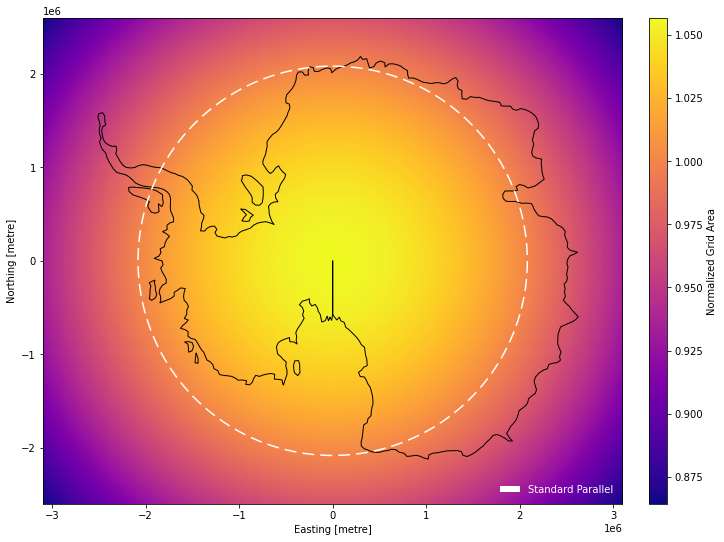

In [10]:
fig,ax3 = plt.subplots(num=3, figsize=(10,7.5))
xmin,xmax,ymin,ymax = (-3100000,3100000,-2600000,2600000)
dx,dy = (10000,10000)
# create a grid of polar stereographic points
X = np.arange(xmin,xmax+dx,dx)
Y = np.arange(ymin,ymax+dy,dy)
gridx,gridy = np.meshgrid(X, Y)
# convert polar stereographic points to latitude/longitude (WGS84)
gridlon,gridlat = transformer.transform(gridx, gridy,
    direction=pyproj.enums.TransformDirection.INVERSE)
# calculate and plot grid area
cf = crs3031.to_cf()
flat = 1.0/cf['inverse_flattening']
gridarea = scale_areas(gridlat, flat=flat, ref=cf['standard_parallel'])
im = ax3.imshow(gridarea,
    extent=(xmin,xmax,ymin,ymax), 
    interpolation='nearest',
    cmap=plt.cm.get_cmap('plasma'),
    origin='lower')
# add circle around standard parallel
ref_lon = np.arange(360)
ref_lat = np.ones((360))*cf['standard_parallel']
# convert latitude/longitude (WGS84) points to polar stereographic
ref_x,ref_y = transformer.transform(ref_lon, ref_lat,
    direction=pyproj.enums.TransformDirection.FORWARD)
l, = ax3.plot(ref_x, ref_y, '--', color='w', dashes=(8,4), label='Standard Parallel')
# add coastlines
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).to_crs(crs3031)
world.plot(ax=ax3, color='none', edgecolor='black')
# set x and y limits
ax3.set_xlim(xmin,xmax)
ax3.set_ylim(ymin,ymax)
ax3.set_aspect('equal', adjustable='box')
# add x and y labels
x_info,y_info = crs3031.axis_info
ax3.set_xlabel('{0} [{1}]'.format(x_info.name,x_info.unit_name))
ax3.set_ylabel('{0} [{1}]'.format(y_info.name,y_info.unit_name))
# add colorbar
cbar = plt.colorbar(im, cax=fig.add_axes([0.92, 0.08, 0.025, 0.90]))
cbar.ax.set_ylabel('Normalized Grid Area')
cbar.solids.set_rasterized(True)
# add legend
lgd = ax3.legend(loc=4,frameon=False)
lgd.get_frame().set_alpha(1.0)
for line in lgd.get_lines():
    line.set_linewidth(6)
for i,text in enumerate(lgd.get_texts()):
    text.set_color(l.get_color())
fig.subplots_adjust(left=0.06,right=0.9,bottom=0.08,top=0.98)

Why is there a black line to the pole?  Because this coastline was reprojected from a Equirectangular projection.  That's the bottom of the Equirectangular map.

pyproj CRS Tricks
-----------------

pyproj CRS objects can:

- Be converted to different methods of describing the CRS, such a to a PROJ string or WKT

In [11]:
proj3031 = crs3031.to_proj4()
wkt3031 = crs3031.to_wkt()
print(proj3031)

+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs


In [12]:
assert(crs3031.is_exact_same(pyproj.CRS.from_wkt(wkt3031)))

- Provide information about each coordinate reference system, such as the name, area of use and axes units.

In [13]:
for EPSG in (3031,3413,5936,6931,6932):
  crs = pyproj.CRS.from_epsg(EPSG)
  x_info,y_info = crs.axis_info
  print(f'{crs.name} ({EPSG})')
  print(f'\tRegion: {crs.area_of_use.name}')
  print(f'\tScope: {crs.scope}')
  print(f'\tAxes: {x_info.name} ({x_info.unit_name}), {y_info.name} ({y_info.unit_name})')

WGS 84 / Antarctic Polar Stereographic (3031)
	Region: Antarctica.
	Scope: Antarctic Digital Database and small scale topographic mapping.
	Axes: Easting (metre), Northing (metre)
WGS 84 / NSIDC Sea Ice Polar Stereographic North (3413)
	Region: Northern hemisphere - north of 60°N onshore and offshore, including Arctic.
	Scope: Polar research.
	Axes: Easting (metre), Northing (metre)
WGS 84 / EPSG Alaska Polar Stereographic (5936)
	Region: Northern hemisphere - north of 60°N onshore and offshore, including Arctic.
	Scope: Arctic small scale mapping - Alaska-centred.
	Axes: Easting (metre), Northing (metre)
WGS 84 / NSIDC EASE-Grid 2.0 North (6931)
	Region: Northern hemisphere.
	Scope: Environmental science - used as basis for EASE grid.
	Axes: Easting (metre), Northing (metre)
WGS 84 / NSIDC EASE-Grid 2.0 South (6932)
	Region: Southern hemisphere.
	Scope: Environmental science - used as basis for EASE grid.
	Axes: Easting (metre), Northing (metre)


- Get coordinate reference system metadata for including in files


In [14]:
print('Climate and Forecast (CF) conventions')
cf = pyproj.CRS.from_epsg(5936).to_cf()
for key,val in cf.items():
    print(f'\t{key}: {val}')

Climate and Forecast (CF) conventions
	crs_wkt: PROJCRS["WGS 84 / EPSG Alaska Polar Stereographic",BASEGEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER["World Geodetic System 1984 (Transit)"],MEMBER["World Geodetic System 1984 (G730)"],MEMBER["World Geodetic System 1984 (G873)"],MEMBER["World Geodetic System 1984 (G1150)"],MEMBER["World Geodetic System 1984 (G1674)"],MEMBER["World Geodetic System 1984 (G1762)"],MEMBER["World Geodetic System 1984 (G2139)"],ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[2.0]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4326]],CONVERSION["EPSG Alaska Polar Stereographic",METHOD["Polar Stereographic (variant A)",ID["EPSG",9810]],PARAMETER["Latitude of natural origin",90,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8801]],PARAMETER["Longitude of natural origin",-150,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["Scale factor at natural origin",0.994,SC

- Be used to build transformer objects for converting coordinate systems
- And a whole lot more!

Geospatial Data
---------------

What is Geospatial Data?  Data that has location information associated with it.

Geospatial data comes in two flavors: _vector_ and _raster_
- Vector data is composed of points, lines, and polygons
- Raster data is composed of individual grid cells

[![Vector vs. Raster](https://developers.planet.com/planetschool/images/vectorraster.png)](https://developers.planet.com/planetschool/geospatial-data/)

_Vector vs. Raster from [Planet School](https://developers.planet.com/planetschool)_

### **Q: When would we use vector over raster?**
### **Q: When would we use raster over vector?**

Vector data will provide geometric information for every point or vertex in the geometry.

Raster data will provide geometric information for a particular corner, which can be combined with the grid cell sizes and grid dimensions to get the grid cell coordinates.

Common vector file formats:
- GeoJSON
- shapefile
- GeoPackage
- ESRI geodatabase
- kml/kmz

Common raster file formats:
- geotiff/cog
- jpeg
- png
- netCDF
- HDF5

All geospatial data (raster and vector) should have metadata for extracting the coordinate reference system of the data.  Some of this metadata is not included with the files but can be found in the documentation.

### **Q: Are you more familiar with using vector or raster data?**
### **Q: Do you more often use GIS software or command-line tools?**

There are different tools for working with raster and vector data.  Some are more advantageous for one data type over the other.

Let's find the coordinate reference system of some data products using some common geospatial tools.

Geospatial Data Abstraction Library
-----------------------------------

The [Geospatial Data Abstraction Library (GDAL/OGR)](https://gdal.org/) is a powerful piece of software. 

It can read, write and query a wide variety of raster and vector geospatial data formats, transform the coordinate system of images, and manipulate other forms of geospatial data.

It is the backbone of a _large_ suite of geospatial libraries and programs.

<!-- It can also be an absolute pain in the neck to install, particularly if you are wanting specific drivers not included in the [default installation](https://trac.osgeo.org/gdal/wiki/BuildingOnUnix).-->

There are a number of wrapper libraries (e.g. [rasterio](https://rasterio.readthedocs.io/), [rioxarray](https://corteva.github.io/rioxarray), [shapely](https://shapely.readthedocs.io/), [fiona](https://fiona.readthedocs.io/)) that provide more user-friendly interfaces with GDAL functionality.

Similar to pyproj CRS objects, GDAL `SpatialReference` functions can provide a lot of information about a particular Coordinate Reference System

In [15]:
def crs_attributes(srs_proj4=None, srs_wkt=None, srs_epsg=None, **kwargs):
    """
    Return a dictionary of attributes for a projection
    """
    # output projection attributes dictionary
    crs = {}
    # set the spatial projection reference information
    sr = osgeo.osr.SpatialReference()
    if srs_proj4 is not None:
        sr.ImportFromProj4(srs_proj4)
    elif srs_wkt is not None:
        sr.ImportFromWkt(srs_wkt)
    elif srs_epsg is not None:
        sr.ImportFromEPSG(srs_epsg)
    else:
        return
    # convert proj4 string to dictionary
    proj4_dict = {p[0]:p[1] for p in re.findall(r'\+(.*?)\=([^ ]+)',sr.ExportToProj4())}
    # get projection attributes
    try:
        crs['spatial_epsg'] = int(sr.GetAttrValue('AUTHORITY',1))
    except Exception as e:
        pass
    crs['crs_wkt'] = sr.ExportToWkt()
    crs['spatial_ref'] = sr.ExportToWkt()
    crs['proj4_params'] = sr.ExportToProj4()
    # get datum attributes
    crs['semi_major_axis'] = sr.GetSemiMajor()
    crs['semi_minor_axis'] = sr.GetSemiMinor()
    crs['inverse_flattening'] = sr.GetInvFlattening()
    crs['reference_ellipsoid_name'] = sr.GetAttrValue('DATUM',0)
    crs['geographic_crs_name'] = sr.GetAttrValue('GEOGCS',0)
    # get projection attributes
    try:
        crs['projected_crs_name'] = sr.GetName()
    except Exception as e:
        pass
    crs['grid_mapping_name'] = sr.GetAttrValue('PROJECTION',0).lower()
    crs['standard_name'] = sr.GetAttrValue('PROJECTION',0)
    crs['prime_meridian_name'] = sr.GetAttrValue('PRIMEM',0)
    crs['longitude_of_prime_meridian'] = float(sr.GetAttrValue('PRIMEM',1))
    try:
        crs['latitude_of_projection_origin'] = float(proj4_dict['lat_0'])
    except Exception as e:
        pass
    crs['standard_parallel'] = float(sr.GetProjParm(osgeo.osr.SRS_PP_LATITUDE_OF_ORIGIN,1))
    crs['straight_vertical_longitude_from_pole'] = float(sr.GetProjParm(osgeo.osr.SRS_PP_CENTRAL_MERIDIAN,1))
    crs['false_northing'] = float(sr.GetProjParm(osgeo.osr.SRS_PP_FALSE_NORTHING,1))
    crs['false_easting'] = float(sr.GetProjParm(osgeo.osr.SRS_PP_FALSE_EASTING,1))
    crs['scale_factor'] = float(sr.GetProjParm(osgeo.osr.SRS_PP_SCALE_FACTOR,1))
    return crs

In [16]:
for key,val in crs_attributes(srs_epsg=5936).items():
  print(key,val)

spatial_epsg 5936
crs_wkt PROJCS["WGS 84 / EPSG Alaska Polar Stereographic",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",90],PARAMETER["central_meridian",-150],PARAMETER["scale_factor",0.994],PARAMETER["false_easting",2000000],PARAMETER["false_northing",2000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",SOUTH],AXIS["Northing",SOUTH],AUTHORITY["EPSG","5936"]]
spatial_ref PROJCS["WGS 84 / EPSG Alaska Polar Stereographic",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Polar_Stereograph

GDAL command-line utilities also allows for quick inspection of Coordinate Reference Systems (CRS) and geospatial data files

In [17]:
! gdalsrsinfo EPSG:5936


PROJ.4 : +proj=stere +lat_0=90 +lon_0=-150 +k=0.994 +x_0=2000000 +y_0=2000000 +datum=WGS84 +units=m +no_defs

OGC WKT2:2018 :
PROJCRS["WGS 84 / EPSG Alaska Polar Stereographic",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            MEMBER["World Geodetic System 1984 (G2139)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["EPSG Alaska Polar Stereographic",
        METHOD["Polar Stereographic (variant

With GDAL, we can access raster and vector data that are available over network-based file systems and virtual file systems

- `/vsicurl/`: http/https/ftp files
- `/vsis3/`: AWS S3 files
- `/vsigs/`: Google Cloud Storage files
- `/vsizip/`: zip archives
- `/vsitar/`: tar/tgz archives
- `/vsigzip/`: gzipped files

These can be chained together to access compressed files over networks

GDAL environment variables can often hava a large impact on performance when reading data via URLs. For example `GDAL_DISABLE_READDIR_ON_OPEN=EMPTY_DIR` disables scaning directories, which is very fast on a local file system, but very slow when querying a server.

Vector Data
-----------

We can use GDAL virtual file systems to access the intermediate resolution shapefile of the [Global Self-consistent, Hierarchical, High-resolution Geography Database](https://www.soest.hawaii.edu/pwessel/gshhg/) from its https server.

`ogrinfo` is a GDAL/OGR tool for inspecting vector data.  We'll get a summary (`-so`) of all data (`-al`) in read-only mode (`-ro`).

In [18]:
! GDAL_DISABLE_READDIR_ON_OPEN=EMPTY_DIR ogrinfo -ro -al -so '/vsizip//vsicurl/http://www.soest.hawaii.edu/pwessel/gshhg/gshhg-shp-2.3.7.zip/GSHHS_shp/i/GSHHS_i_L1.shp'

INFO: Open of `/vsizip//vsicurl/http://www.soest.hawaii.edu/pwessel/gshhg/gshhg-shp-2.3.7.zip/GSHHS_shp/i/GSHHS_i_L1.shp'
      using driver `ESRI Shapefile' successful.

Layer name: GSHHS_i_L1
Metadata:
  DBF_DATE_LAST_UPDATE=2017-06-15
Geometry: Polygon
Feature Count: 32830
Extent: (-180.000000, -68.919814) - (180.000000, 83.633389)
Layer SRS WKT:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["latitude",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["longitude",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
id: String (80.0)
level: Integer (9.0)
source: String (80.0)
parent_id: Integer (9.0)
sibling_id: Integer (9.0)
area: Real (24.15)


So from `ogrinfo` we can see that this shapefile is in `EPSG:4326` (WGS84 Latitude/Longitude).

We can read these shapefiles using geopandas, which uses a wrapper of GDAL/OGR for reading vector data

In [19]:
%%time

#CPU times: user 1.51 s, sys: 114 ms, total: 1.63 s
#Wall time: 5.97 s

#1.65 later due to caching

gshhg = gpd.read_file('/vsizip//vsicurl/http://www.soest.hawaii.edu/pwessel/gshhg/gshhg-shp-2.3.7.zip/GSHHS_shp/i/GSHHS_i_L1.shp')
print(gshhg.crs)

epsg:4326
CPU times: user 1.48 s, sys: 165 ms, total: 1.64 s
Wall time: 7.11 s


Let's use these coastlines to make a plot of Greenland in a [Polar Stereographic projection (EPSG:3413)](https://epsg.io/3413)

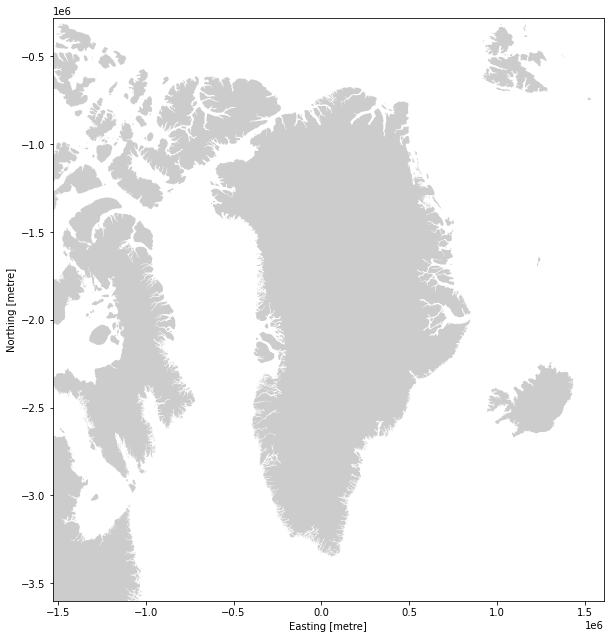

In [20]:
fig,ax4 = plt.subplots(num=4, figsize=(9,9))
crs3413 = pyproj.CRS.from_epsg(3413)
xmin,xmax,ymin,ymax = (-1530000, 1610000,-3600000, -280000)
# add coastlines
gshhg.to_crs(crs3413).plot(ax=ax4, color='0.8', edgecolor='none')
# set x and y limits
ax4.set_xlim(xmin,xmax)
ax4.set_ylim(ymin,ymax)
ax4.set_aspect('equal', adjustable='box')
# add x and y labels
x_info,y_info = crs3413.axis_info
ax4.set_xlabel('{0} [{1}]'.format(x_info.name,x_info.unit_name))
ax4.set_ylabel('{0} [{1}]'.format(y_info.name,y_info.unit_name))
# adjust subplot and show
fig.subplots_adjust(left=0.06,right=0.98,bottom=0.08,top=0.98)

Even with intermediate resolution, we can add much better coastlines than the ones that ship with geopandas!

All coastline resolutions available:
- `c`: coarse
- `l`: low
- `i`: intermediate
- `h`: high
- `f`: full

Raster Data
-----------

The same virtual file system commands can be used with raster images.

Let's inspect some geotiff imagery from the Landsat program.

`gdalinfo` allows us to inspect the format, size, geolocation and Coordinate Reference System of raster imagery.  Appending the `-proj4` option will additionally output the PROJ string associated with this geotiff image.

In [21]:
! GDAL_DISABLE_READDIR_ON_OPEN=EMPTY_DIR gdalinfo -proj4 "/vsicurl/https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20181224_20190129_01_T1/LC08_L1TP_046027_20181224_20190129_01_T1_B8.TIF"


Driver: GTiff/GeoTIFF
Files: /vsicurl/https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20181224_20190129_01_T1/LC08_L1TP_046027_20181224_20190129_01_T1_B8.TIF
Size is 15541, 15761
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 10N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 10N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-123,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["uni

This image is projected in Universal Transverse Mercator (UTM), which divides the Earth into [60 north-south oriented zones](https://pubs.usgs.gov/fs/2001/0077/report.pdf) (each 6° longitude wide).

We can read geotiff files using rasterio, which is a wrapper of GDAL for reading raster data

Let's find out where this image is by _warping_ the outline of the image to latitude and longitude coordinates.

In [22]:
# Environment variables in Python can be set via the 'os' library
os.environ['GDAL_DISABLE_READDIR_ON_OPEN'] = 'EMPTY_DIR'

driver: GTiff
dtype: uint16
nodata: None
width: 15541
height: 15761
count: 1
crs: EPSG:32610
transform: | 15.00, 0.00, 472792.50|
| 0.00,-15.00, 5373307.50|
| 0.00, 0.00, 1.00|
blockxsize: 256
blockysize: 256
tiled: True
compress: lzw
interleave: band


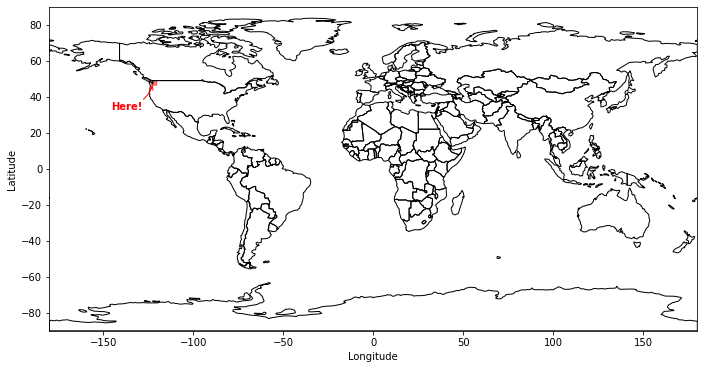

In [23]:
url = "/vsicurl/https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20181224_20190129_01_T1/LC08_L1TP_046027_20181224_20190129_01_T1_B8.TIF"
with rasterio.open(url) as ds:
    for key,val in ds.profile.items():
        print(f'{key}: {val}')

    # read the valid data mask as a ndarray.
    mask = ds.dataset_mask()
    # extract feature shapes and values from the array.
    for geom, val in rasterio.features.shapes(mask, transform=ds.transform):
        # transform shapes to EPSG:4326
        geometry = rasterio.warp.transform_geom(ds.crs, 'EPSG:4326', geom, precision=6)

    # plot location of landsat image
    fig,ax1 = plt.subplots(num=1, figsize=(10.375,5.0))
    minlon,maxlon,minlat,maxlat = (-180,180,-90,90)
    # add geometry of image
    poly = matplotlib.patches.Polygon(geometry['coordinates'][0],facecolor='red',edgecolor='red',alpha=0.5)
    ax1.add_patch(poly)
    # add annotation
    xy = np.mean(poly.get_xy(),axis=0)
    ax1.annotate("Here!", xy=xy, xytext=(xy - 15.0),
        arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=0.3",color='red'),
        bbox=dict(boxstyle="square", fc="w", ec="w", pad=0.1),
        color='red', weight='bold', xycoords='data', ha='center')
    # add coastlines
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world.plot(ax=ax1, color='none', edgecolor='black')
    # set x and y limits
    ax1.set_xlim(minlon,maxlon)
    ax1.set_ylim(minlat,maxlat)
    ax1.set_aspect('equal', adjustable='box')
    # add x and y labels
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    # adjust subplot and show
    fig.subplots_adjust(left=0.06,right=0.98,bottom=0.08,top=0.98)


Okay! It covers Western Washington and the University of Washington.

Let's see what this image looks like first in the original image coordinates (UTM)

We'll read the image data using rasterio and plot it directly with matplotlib

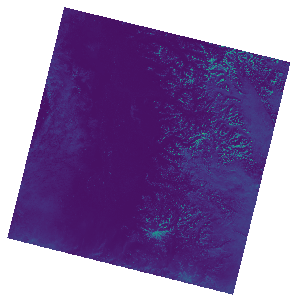

In [24]:
url = "/vsicurl/https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20181224_20190129_01_T1/LC08_L1TP_046027_20181224_20190129_01_T1_B8.TIF"
with rasterio.open(url) as ds:
    # read image
    image = np.ma.zeros((ds.count,ds.height,ds.width),dtype=ds.dtypes[0],fill_value=0)
    image.mask = np.zeros((ds.count,ds.height,ds.width), dtype=bool)
    image.data[...] = ds.read(ds.indexes)
    image.mask[image.data == 0] = True
    image.data[image.mask] = image.fill_value
    # save the coordinate reference system and transform
    src_crs = ds.crs
    src_transform = ds.transform

    # create figure axis
    fig, ax = plt.subplots(num=5)
    im = ax.imshow(image[0,:,:],
        interpolation='nearest',
        extent=(ds.bounds.left,ds.bounds.right,ds.bounds.bottom,ds.bounds.top),
        origin='upper')
    # set x and y limits
    ax.set_xlim(ds.bounds.left,ds.bounds.right)
    ax.set_ylim(ds.bounds.bottom,ds.bounds.top)
    # turn of frame and ticks
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.axis('off')
    # adjust subplot within figure
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

Warping Raster Imagery
----------------------

_Warping_ transfers a raster image from one Coordinate Reference System (CRS) into another.

We can use [GDAL to reproject the imagery data](https://gdal.org/programs/gdalwarp.html) into another CRS or change the pixel resolution of the raster image.

Ground control points (GCPs) can also be applied to georeference raw maps or imagery.

![ESRI warp](https://www.esri.com/about/newsroom/wp-content/uploads/2018/07/auspr18_Georefer_2.gif)

_Raster Georeferencing from [ESRI](https://www.esri.com/about/newsroom/arcuser/understanding-raster-georeferencing/)_

`gdalwarp` is a GDAL tool for warping raster data.  We'll warp this image into `EPSG:4326` (WGS84 Latitude/Longitude) using bilinear interpolation as the resampling method (`-r`).  We'll set the target extent (`-te`) and target resolution (`-tr`) of our output geotiff image.

In [25]:
%%bash
# remove any previous instance of file
if [ -f LC08_L1TP_046027_20181224_20190129_01_T1_B8.TIF ]; then
  rm -v LC08_L1TP_046027_20181224_20190129_01_T1_B8.TIF
fi
# warp landsat image using GDAL command line tools
export url="/vsicurl/https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20181224_20190129_01_T1/LC08_L1TP_046027_20181224_20190129_01_T1_B8.TIF"
gdalwarp -co "COMPRESS=LZW" -te -124 46 -120 49 -tr 0.01 0.01 \
   -t_srs EPSG:4326 -srcnodata 0 -dstnodata 0 \
   -r bilinear ${url} /tmp/LC08_L1TP_046027_20181224_20190129_01_T1_B8.TIF
ls -lh /tmp/LC08_L1TP_046027_20181224_20190129_01_T1_B8.TIF

ERROR 1: Output dataset /tmp/LC08_L1TP_046027_20181224_20190129_01_T1_B8.TIF exists,
but some command line options were provided indicating a new dataset
should be created.  Please delete existing dataset and run again.



-rw-r--r-- 1 jovyan jovyan 134K Mar 16 00:16 /tmp/LC08_L1TP_046027_20181224_20190129_01_T1_B8.TIF


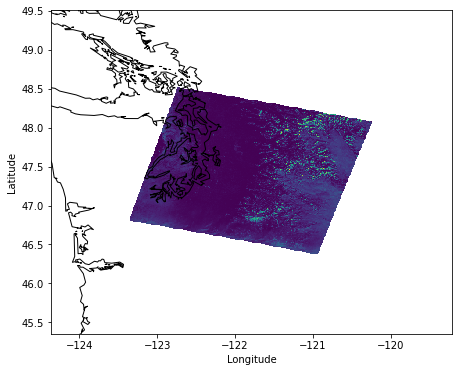

In [26]:
with rasterio.open('/tmp/LC08_L1TP_046027_20181224_20190129_01_T1_B8.TIF') as ds:
    # read warped landsat image
    warped = np.ma.zeros((ds.count,ds.height,ds.width),dtype=ds.dtypes[0],fill_value=0)
    warped.mask = np.zeros((ds.count,ds.height,ds.width), dtype=bool)
    warped.data[...] = ds.read(ds.indexes)
    warped.mask[warped.data == 0] = True
    warped.data[warped.mask] = warped.fill_value
    xmin,xmax,ymin,ymax=(ds.bounds.left,ds.bounds.right,ds.bounds.bottom,ds.bounds.top)

    # plot warped landsat image
    fig,ax1 = plt.subplots(num=1, figsize=(10.375,5.0))
    # add geometry of image
    ax1.imshow(warped[0,:,:],
        interpolation='nearest',
        extent=(xmin,xmax,ymin,ymax),
        origin='upper')
    # add coastlines
    gshhg.plot(ax=ax1, color='none', edgecolor='black')
    # set x and y limits
    ax1.set_xlim(xmin-1,xmax+1)
    ax1.set_ylim(ymin-1,ymax+1)
    ax1.set_aspect('equal', adjustable='box')
    # add x and y labels
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    # adjust subplot and show
    fig.subplots_adjust(left=0.06,right=0.98,bottom=0.08,top=0.98)

Q: can we do this directly with rasterio?

Yes!

Rasterio Transforms
-------------------

For every rasterio object, there is an associated _affine transform_ (`ds.transform`), which allows you to [transfer from image coordinates to geospatial coordinates](https://rasterio.readthedocs.io/en/latest/quickstart.html#dataset-georeferencing).

<p align="center">
$
x = A*row + B*col + C\\
y = D*row + E*col + F
$
</p>

_Affine Transformation_: maps between pixel locations in `(row, col)` coordinates to `(x, y)` spatial positions:

`x,y = ds.transform*(row,col)`

Upper left coordinate:
- `row = 0`
- `col = 0`

Lower right coordinate:
- `row = ds.width`
- `col = ds.height`


![ESRI affine](https://www.esri.com/about/newsroom/wp-content/uploads/2018/07/aufall18_Georefer_1.gif)

_Raster Georeferencing from [ESRI](https://www.esri.com/about/newsroom/arcuser/understanding-raster-georeferencing/)_

We use the affine transformations for warping our raster image into `EPSG:4326` (WGS84 Latitude/Longitude).

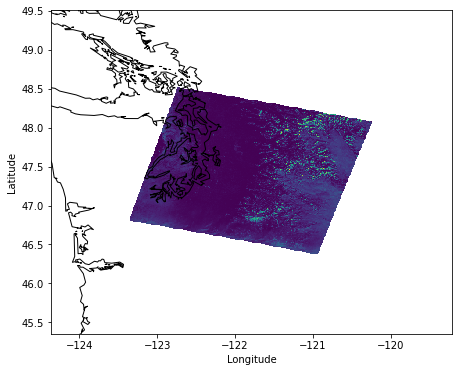

In [27]:
# transform image to EPSG:4326
warped,affine = rasterio.warp.reproject(image.data, src_transform=src_transform,
  src_crs=src_crs, src_nodata=0, dst_crs=crs4326,
  dst_resolution=(0.01,0.01), resampling=rasterio.enums.Resampling.bilinear)
dst_count,dst_height,dst_width = warped.shape
xmin,ymax = affine*(0,0)
xmax,ymin = affine*(dst_width,dst_height)
# convert to masked array with fill values
warped = np.ma.array(warped, dtype=ds.dtypes[0], fill_value=0)
warped.mask = np.zeros_like(warped, dtype=bool)
warped.mask[warped.data == 0] = True
warped.data[warped.mask] = warped.fill_value

# plot warped landsat image
fig,ax1 = plt.subplots(num=1, figsize=(10.375,5.0))
# add geometry of image
ax1.imshow(warped[0,:,:],
    interpolation='nearest',
    extent=(xmin,xmax,ymin,ymax),
    origin='upper')
# add coastlines
gshhg.plot(ax=ax1, color='none', edgecolor='black')
# set x and y limits
ax1.set_xlim(xmin-1,xmax+1)
ax1.set_ylim(ymin-1,ymax+1)
ax1.set_aspect('equal', adjustable='box')
# add x and y labels
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
# adjust subplot and show
fig.subplots_adjust(left=0.06,right=0.98,bottom=0.08,top=0.98)

Saving Raster Data with Rasterio
================================

In [28]:
# write an array as a raster band
profile = dict(
    driver='GTiff',
    dtype=warped.dtype,
    nodata=warped.fill_value,
    width=dst_width,
    height=dst_height,
    count=dst_count,
    crs=crs4326,
    transform=affine
)

# Save to scratch space instead of within limited home directory
with rasterio.open('/tmp/LC08_L1TP_046027_20181224_20190129_01_T1_B8.TIF', 'w', **profile) as ds:
    ds.write(warped)

In [29]:
! gdalinfo /tmp/LC08_L1TP_046027_20181224_20190129_01_T1_B8.TIF

Driver: GTiff/GeoTIFF
Files: /tmp/LC08_L1TP_046027_20181224_20190129_01_T1_B8.TIF
Size is 316, 216
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-123.368396124162160,48.512881673244252)
Pixel Size = (0.010000000000000,-0.010000000000000)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-123.3683961,  48.5128817) (123d22' 6.23"W, 48d30'46.37"N)
Lower Left  (-123.3683961,  46.3528817) (123d22' 6.23"W, 46d21'10.37

Climate and Forecast (CF) Metadata Conventions
==============================================
NASA adopted the [Climate and Forecast (CF) conventions](http://cfconventions.org/) as the [standard for NASA Science Data Systems (SDS)](https://earthdata.nasa.gov/esdis/esco/standards-and-references/climate-and-forecast-cf-metadata-conventions).  The CF metadata standards were designed to ease the processing and sharing of Earth sciences netCDF data.  It follows and extends geospatial data guidelines and standards from the [Federal Geographic Data Committee (FGDC)](https://www.fgdc.gov/standards/projects/FGDC-standards-projects/metadata/base-metadata/v2_0698.pdf), [Cooperative Ocean/Atmosphere Research Data Service (COARDS)](https://ferret.pmel.noaa.gov/noaa_coop/coop_cdf_profile.html), and other earlier sources, such as the Gregory/Drach/Tett (GDT) conventions.

For grid fields in netCDF files following CF standards, there is a variable attribute named `grid_mapping`.  This attribute contains the name of the variable describing the Coordinate Reference System (CRS) of the geospatial field.

Common attributes for a [CF grid mapping variable](https://cfconventions.org/):

- `grid_mapping_name`: [name of the grid mapping](https://cfconventions.org/Data/cf-conventions/cf-conventions-1.7/build/apf.html)  _(required)_
- `crs_wkt`: Well-Known Text (WKT) of the Coordinate Reference System (CRS)
- `semi_major_axis`: semi-major axis of the ellipsoid
- `semi_minor_axis`: semi-minor axis of the ellipsoid
- `inverse_flattening`: ellipsoidal flattening <!--(difference between the semi-major axis and the semi-minor axis divided by the semi-major axis)-->
- `reference_ellipsoid_name`: name of the ellipsoid
- `geographic_crs_name`: name of the geographic coordinate reference system
- `longitude_of_prime_meridian`: longitude of the Prime Meridian
- `prime_meridian_name`: name of the Prime Meridian

In ICESat-2 ATL15 gridded land ice height change products, the data is separated into individual groups:
- `delta_h`: group with height anomalies at quarterly time steps
- `dhdt_lag1`: group with height difference rates between quarterly time steps
- `dhdt_lag4`: group with annual height change rates at quarterly time steps
- `dhdt_lag8`: group with biennial height change rates at quarterly time steps

These groups each contain a `grid_mapping` variable `polar_stereographic` that contains the CF standard Coordinate Reference System (CRS) attributes.

In [ ]:
HOST = 'urs.earthdata.nasa.gov'
username = builtins.input('Username for {0}: '.format(HOST))
password = getpass.getpass(prompt='Password for {0}@{1}:'.format(username,HOST))

In [30]:
# query CMR for ATL15 files
ids,urls = utilities.cmr(product='ATL15',regions='GL',resolutions='10km',verbose=False)
buffer,response_error = utilities.from_nsidc(urls[0], username=username,
    password=password, local=os.path.join('/tmp',ids[0]))
# open the ATL15 netCDF4 file with xarray
ds = xr.open_dataset(buffer, group='dhdt_lag8')
ds

<xarray.Dataset>
Dimensions:              (x: 160, y: 280, time: 4)
Coordinates:
  * x                    (x) float64 -6.77e+05 -6.67e+05 ... 9.03e+05 9.13e+05
  * y                    (y) float64 -3.397e+06 -3.387e+06 ... -6.07e+05
  * time                 (time) datetime64[ns] 2019-10-02T04:30:00 ... 2020-0...
Data variables:
    Polar_Stereographic  int8 ...
    dhdt                 (time, y, x) float32 ...
    dhdt_sigma           (time, y, x) float32 ...
Attributes:
    description:  dhdt_lag8 group includes variables describing biennial heig...

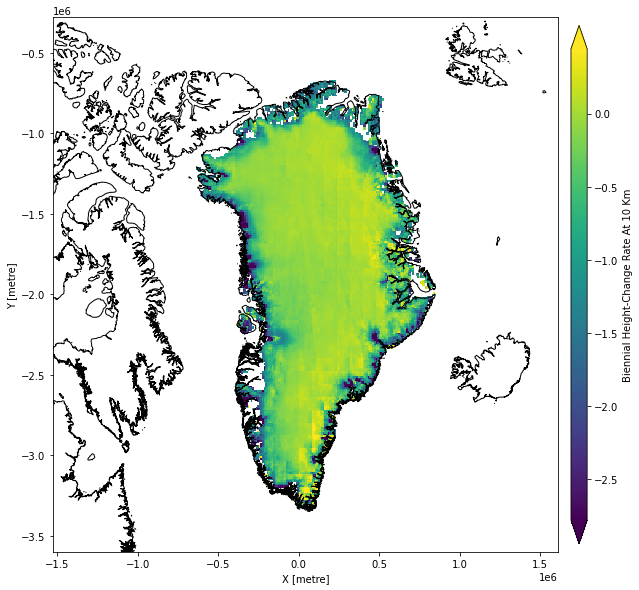

In [31]:
fig,ax4 = plt.subplots(num=4, figsize=(9,9))
# get coordinate reference system of ATL15
field = 'dhdt'
grid_mapping_name = ds[field].grid_mapping
crs = pyproj.CRS.from_wkt(ds[grid_mapping_name].crs_wkt)
# extents of output image
xmin,xmax,ymin,ymax = (-1530000, 1610000,-3600000, -280000)
# extents of ATL15 image
extent = (ds['x'].min(),ds['x'].max(),ds['y'].min(),ds['y'].max())
# get vmin and vmax from all ATL15 values
vmin,vmax = np.nanquantile(np.ma.filled(ds[field], np.nan), (0.01, 0.99))
# add ATL15 image for field
im = ax4.imshow(ds[field][0,:,:],
    extent=extent, vmin=vmin, vmax=vmax,
    interpolation='nearest',
    cmap=plt.cm.get_cmap('viridis'),
    origin='lower')
# add coastlines
gshhg.to_crs(crs).plot(ax=ax4, color='none', edgecolor='black')
# set x and y limits
ax4.set_xlim(xmin,xmax)
ax4.set_ylim(ymin,ymax)
ax4.set_aspect('equal', adjustable='box')
# add x and y labels
x_info,y_info = crs.axis_info
ax4.set_xlabel('{0} [{1}]'.format(x_info.name,x_info.unit_name))
ax4.set_ylabel('{0} [{1}]'.format(y_info.name,y_info.unit_name))
# add colorbar
cbar = plt.colorbar(im, cax=fig.add_axes([0.86, 0.13, 0.025, 0.8]),
    extend='both')
cbar.ax.set_ylabel(ds[field].long_name.title())
cbar.solids.set_rasterized(True)
# adjust subplot and show
fig.subplots_adjust(left=0.06,right=0.84,bottom=0.08,top=0.98)

#### Converting netCDF4 to Cloud Optimized GeoTIFF (COG)
GDAL has a translation tool for converting raster data between different formats.  If GDAL is compiled with the netCDF4 driver, then fields from gridded ICESat-2 land ice height files can be converted to other raster formats (such as GeoTIFFs) because the files contain the necessary CRS metadata.

In [32]:
%%bash
gdal_translate -co "COMPRESS=LZW" -co "BIGTIFF=YES" \
  NETCDF:/tmp/ATL15_GL_0311_10km_001_01.nc:delta_h/delta_h \
  -of 'cog' /tmp/ATL15_GL_delta_h_0311_10km_001_01.tif
gdalinfo -proj4 -nomd /tmp/ATL15_GL_delta_h_0311_10km_001_01.tif

Input file size is 160, 280
0...10...20...30...40...50...60...70...80...90...100 - done.
Driver: GTiff/GeoTIFF
Files: /tmp/ATL15_GL_delta_h_0311_10km_001_01.tif
Size is 160, 280
Coordinate System is:
PROJCRS["WGS 84 / NSIDC Sea Ice Polar Stereographic North",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            MEMBER["World Geodetic System 1984 (G2139)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSIO

## Combining Concepts: Comparing Datasets
Here, we're going to combine some concepts of geospatial transforms for ICESat-2 applications

First, we'll download a granule of ICESat-2 ATL06 land ice heights for a region of Antarctica

This is _along-track_ data stored in an HDF5 file with geospatial coordinates latitude and longtude (WGS84)

We'll download the HDF5 data from the [National Snow and Ice Data Center (NSIDC)](https://nsidc.org/data/atl06), and merge it into a single GeoDataFrame. 

In [33]:
# query CMR for ATL06 files
ids,urls = utilities.cmr(product='ATL06',release='005',cycles=3,tracks=483,granules=11,verbose=False)
# ICESat-2 ATL06 files as geodataframe
atl06 = gpd.GeoDataFrame(geometry=gpd.points_from_xy([],[]), crs='EPSG:7661')
for i,url in enumerate(urls):
    # read ATL06 as in-memory file-like object
    buffer,response_error = utilities.from_nsidc(url, username=username, password=password)
    atl06 = atl06.append(ATL06_to_dataframe(buffer, groups=[], crs='EPSG:7661'))

We'll overlay our ICESat-2 data on top of the Reference Elevation Model of Antarctica (REMA), a high resolution Digital Elevation Model (DEM)

The 8m REMA DEM mosaic is tiled into 1,524 individual geotiff files.

We'll start by reading the REMA tile index, a vector file containing the bounds of each DEM tile.  The vector and raster data are both in [Antarctic Polar Stereographic (EPSG:3031)](https://epsg.io/3031) projections.

We'll project our ICESat-2 data to this projection, and _intersect_ the ICESat-2 geolocations with the polygon bounds of each tile.  This will give us the tiles that we could need to read to compare with our ICESat-2 data.

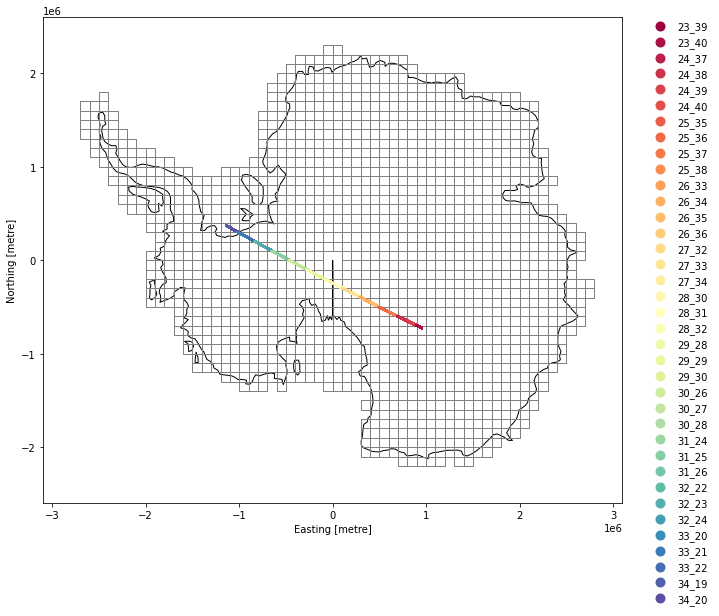

In [34]:
rema = gpd.read_file('/vsizip//vsicurl/https://data.pgc.umn.edu/elev/dem/setsm/REMA/indexes/REMA_Tile_Index_Rel1.1.zip')
tiles = gpd.sjoin(atl06.to_crs(rema.crs), rema, how="inner", op='intersects')

fig,ax3 = plt.subplots(num=3, figsize=(10,7.5))
xmin,xmax,ymin,ymax = (-3100000,3100000,-2600000,2600000) 
# add coastlines
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).to_crs(rema.crs)
world.plot(ax=ax3, color='none', edgecolor='black')
# add polygons of REMA outputs
rema.plot(ax=ax3, color='none', edgecolor='0.5')
# add scatter plot of ATL06 data marked by REMA bin
legend_kwds = dict(bbox_to_anchor=(1.04, 1), loc=2, borderaxespad=0., frameon=False)
tiles.plot('tile', ax=ax3, markersize=0.5, cmap=plt.cm.get_cmap('Spectral'),
   legend=True, categorical=True, legend_kwds=legend_kwds)
# set x and y limits
ax3.set_xlim(xmin,xmax)
ax3.set_ylim(ymin,ymax)
ax3.set_aspect('equal', adjustable='box')
# add x and y labels
x_info,y_info = rema.crs.axis_info
ax3.set_xlabel('{0} [{1}]'.format(x_info.name,x_info.unit_name))
ax3.set_ylabel('{0} [{1}]'.format(y_info.name,y_info.unit_name))
fig.subplots_adjust(left=0.06,right=0.9,bottom=0.08,top=0.98)

In [39]:
fig,ax3 = plt.subplots(num=3, figsize=(10,7.5))
xmin,xmax,ymin,ymax = (-3100000,3100000,-2600000,2600000) 
# iterate over unique tiles
unique = tiles.copy().drop_duplicates(subset='name')
# for time let's just use a single tile
unique = unique.iloc[-2:-1]
# # range of land ice heights
# vmin,vmax = (atl06.h_li.min(),atl06.h_li.max())
for i,row in unique.iterrows():
    url = row['fileurl']
    name = row['name']
    with rasterio.open(f'/vsitar//vsicurl/{url}/{name}_dem.tif') as ds:
        # read image
        image = np.ma.zeros((ds.count,ds.height,ds.width),dtype=ds.dtypes[0],fill_value=ds.nodata)
        image.mask = np.zeros((ds.count,ds.height,ds.width), dtype=bool)
        image.data[...] = ds.read(ds.indexes)
        image.mask[(image.data == image.fill_value) | np.isnan(image.data)] = True
        image.data[image.mask] = image.fill_value
        # save the coordinate reference system, transform and extents
        src_crs = ds.crs
        src_transform = ds.transform
        extent = (ds.bounds.left,ds.bounds.right,ds.bounds.bottom,ds.bounds.top)
        # indices for ATL06 data points
        row,col = ds.index(atl06.to_crs(src_crs).geometry.x,atl06.to_crs(src_crs).geometry.y)
# range of REMA heights
vmin,vmax = (image.min(),image.max())
# create image axis
im = ax3.imshow(image[0,:,:],
    interpolation='nearest',
    extent=extent, vmin=vmin, vmax=vmax,
    origin='upper')
# add scatter plot of ATL06 height data
atl06.to_crs(rema.crs).plot('h_li', ax=ax3, markersize=0.5, vmin=vmin, vmax=vmax)
# set x and y limits
ax3.set_xlim(extent[0]-10e3,extent[1]+10e3)
ax3.set_ylim(extent[2]-10e3,extent[3]+10e3)
ax3.set_aspect('equal', adjustable='box')
# add x and y labels
x_info,y_info = rema.crs.axis_info
ax3.set_xlabel('{0} [{1}]'.format(x_info.name,x_info.unit_name))
ax3.set_ylabel('{0} [{1}]'.format(y_info.name,y_info.unit_name))
# add colorbar
cbar = plt.colorbar(im, cax=fig.add_axes([0.92, 0.08, 0.025, 0.90]))
cbar.ax.set_ylabel('Height Above WGS84 Ellipsoid [m]')
cbar.solids.set_rasterized(True)
# add legend
lgd = ax3.legend(loc=4,frameon=False)
lgd.get_frame().set_alpha(1.0)
for line in lgd.get_lines():
    line.set_linewidth(6)
for i,text in enumerate(lgd.get_texts()):
    text.set_color(l.get_color())
fig.subplots_adjust(left=0.06,right=0.9,bottom=0.08,top=0.98)

In [ ]:
# create figure of Antarctica
fig,ax3 = plt.subplots(num=3, figsize=(10,7.5))
# reduce indices to valid values
_,height,width = np.shape(image)
valid, = np.nonzero((np.array(row) >= 0) & (np.array(row) <= height) & 
    (np.array(col) >= 0) & (np.array(col) <= width))
irow,icol = row[valid],col[valid]
# calculate differences from REMA using nearest-neighbors
atl06['h_diff'] = image[0,irow,icol] - atl06['h_li'].values
# add scatter plot of ATL06 land ice height differences
legend_label = 'Height Difference from REMA [m]'
atl06.to_crs(crs3031).plot('h_diff', ax=ax3, markersize=0.5,
    vmin=-10, vmax=10, legend=True, cmap=plt.cm.get_cmap('PRGn'),
    legend_kwds=dict(label=legend_label, extend='both', shrink=0.90))
# set x and y limits
ax3.set_xlim(extent[0]-10e3,extent[1]+10e3)
ax3.set_ylim(extent[2]-10e3,extent[3]+10e3)
ax3.set_aspect('equal', adjustable='box')
# add x and y labels
x_info,y_info = crs3031.axis_info
ax3.set_xlabel('{0} [{1}]'.format(x_info.name,x_info.unit_name))
ax3.set_ylabel('{0} [{1}]'.format(y_info.name,y_info.unit_name))
fig.subplots_adjust(left=0.06,right=0.9,bottom=0.08,top=0.98)

#### **Q: How could we improve the comparison?**

References
----------

Below is an alphabetical list to all the great open source libraries we used in this notebook

- [geopandas: for geospatial vector data](https://geopandas.org/en/stable/)
- [GEOS: geometry, spatial operations](https://trac.osgeo.org/geos)
- [GDAL/OGR: Pythonic interface to the Geospatial Data Abstraction Library (GDAL)](https://gdal.org)
- [fiona: Python wrapper for vector data access functions from the OGR library](https://fiona.readthedocs.io)
- [matplotlib: visualizations and publication-quality plots](https://matplotlib.org)
- [numpy: Scientific Computing Tools For Python](http://www.numpy.org)
- [pandas: Python Data Analysis Library](https://pandas.pydata.org)
- [PROJ: cartographic projection and coordinate transformation library](https://proj.org)
- [pyproj: Python interface to PROJ library](https://pyproj4.github.io)
- [shapely: PostGIS-ish operations outside a database context for Python](https://shapely.readthedocs.io)